In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from agent.sac import SACContinuous
from agent import rl_utils

from hem.HEM_v0 import sa_env
import yaml
from hem.env.utils import Renderer
from pettingzoo.test import api_test, parallel_api_test

In [2]:
def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    best_agent = None
    best_return = -np.inf
    agent_id = env.agents[0]
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                env_state, _ = env.reset()
                state = env_state[agent_id]
                done = False
                while not done:
                    action = agent.take_action(state)
                    env_action = {agent_id: action}
                    env_next_state, env_reward, env_done, _, _ = env.step(env_action)
                    done = env_done[agent_id]
                    next_state = env_next_state[agent_id]
                    reward = env_reward[agent_id]

                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r,
                                           'dones': b_d}
                        agent.update(transition_dict)

                return_list.append(episode_return)
                if episode_return > best_return:
                    best_return = episode_return
                    best_agent = agent
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                      'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    print(f'Best return: {best_return}')
    return return_list, env, best_agent

In [3]:
config_path = 'hem/env/config_env.yaml'
env_config = yaml.safe_load(open(config_path, 'r', encoding='utf-8'))

env_attr = {
    'random_episode_split': True,
    'rolling_episode_split': False,
    'data_start_end': (0, 122 * 24 * 60),  # 数据集中，一共6，7，8，9月，122天，1分钟一个数据点
    'episode_time_steps': int(24 * 60 / env_config['MINUTES_PER_TIME_STEP']),  # one day, 24 hours
    'mode': 'train',
    'random_seed': 0,
    'noise_strength': 0,
    'config_path': config_path,
    'render_mode': 'None',
}

print(f"{'-' * 20} Testing parallel_env {'-' * 20}")
env = sa_env(**env_attr)
parallel_api_test(env, num_cycles=50)

np.random.seed(0)
torch.manual_seed(0)

-------------------- Testing parallel_env --------------------
Make env: mode: train, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Passed Parallel API test


In [4]:
actor_lr = 3e-4
critic_lr = 3e-4
alpha_lr = 3e-4
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 1_000_000
minimal_size = 1000
batch_size = 256

num_episodes = 300
net_arch = [256, 64, 256]
action_bound = env.action_space(env.agents[0]).high[0]
target_entropy = -env.action_space(env.agents[0]).shape[0]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
state_dim = env.observation_space(env.agents[0]).shape[0]
action_dim = env.action_space(env.agents[0]).shape[0]

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, net_arch, action_dim, action_bound, actor_lr, critic_lr, alpha_lr, target_entropy,
                      tau, gamma, device)

return_list, trained_env, trained_agent = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size,
                                                                 batch_size)

Iteration 3:  67%|██████▋   | 20/30 [00:49<00:24,  2.48s/it, episode=110, return=150.018]


KeyboardInterrupt: 

In [5]:
plt.plot(return_list)
plt.show()

NameError: name 'return_list' is not defined

Make env: mode: test, whole_days: 122, train_days: 106, val_days: 16, test_days: 16
Episode Time: (288, 575)


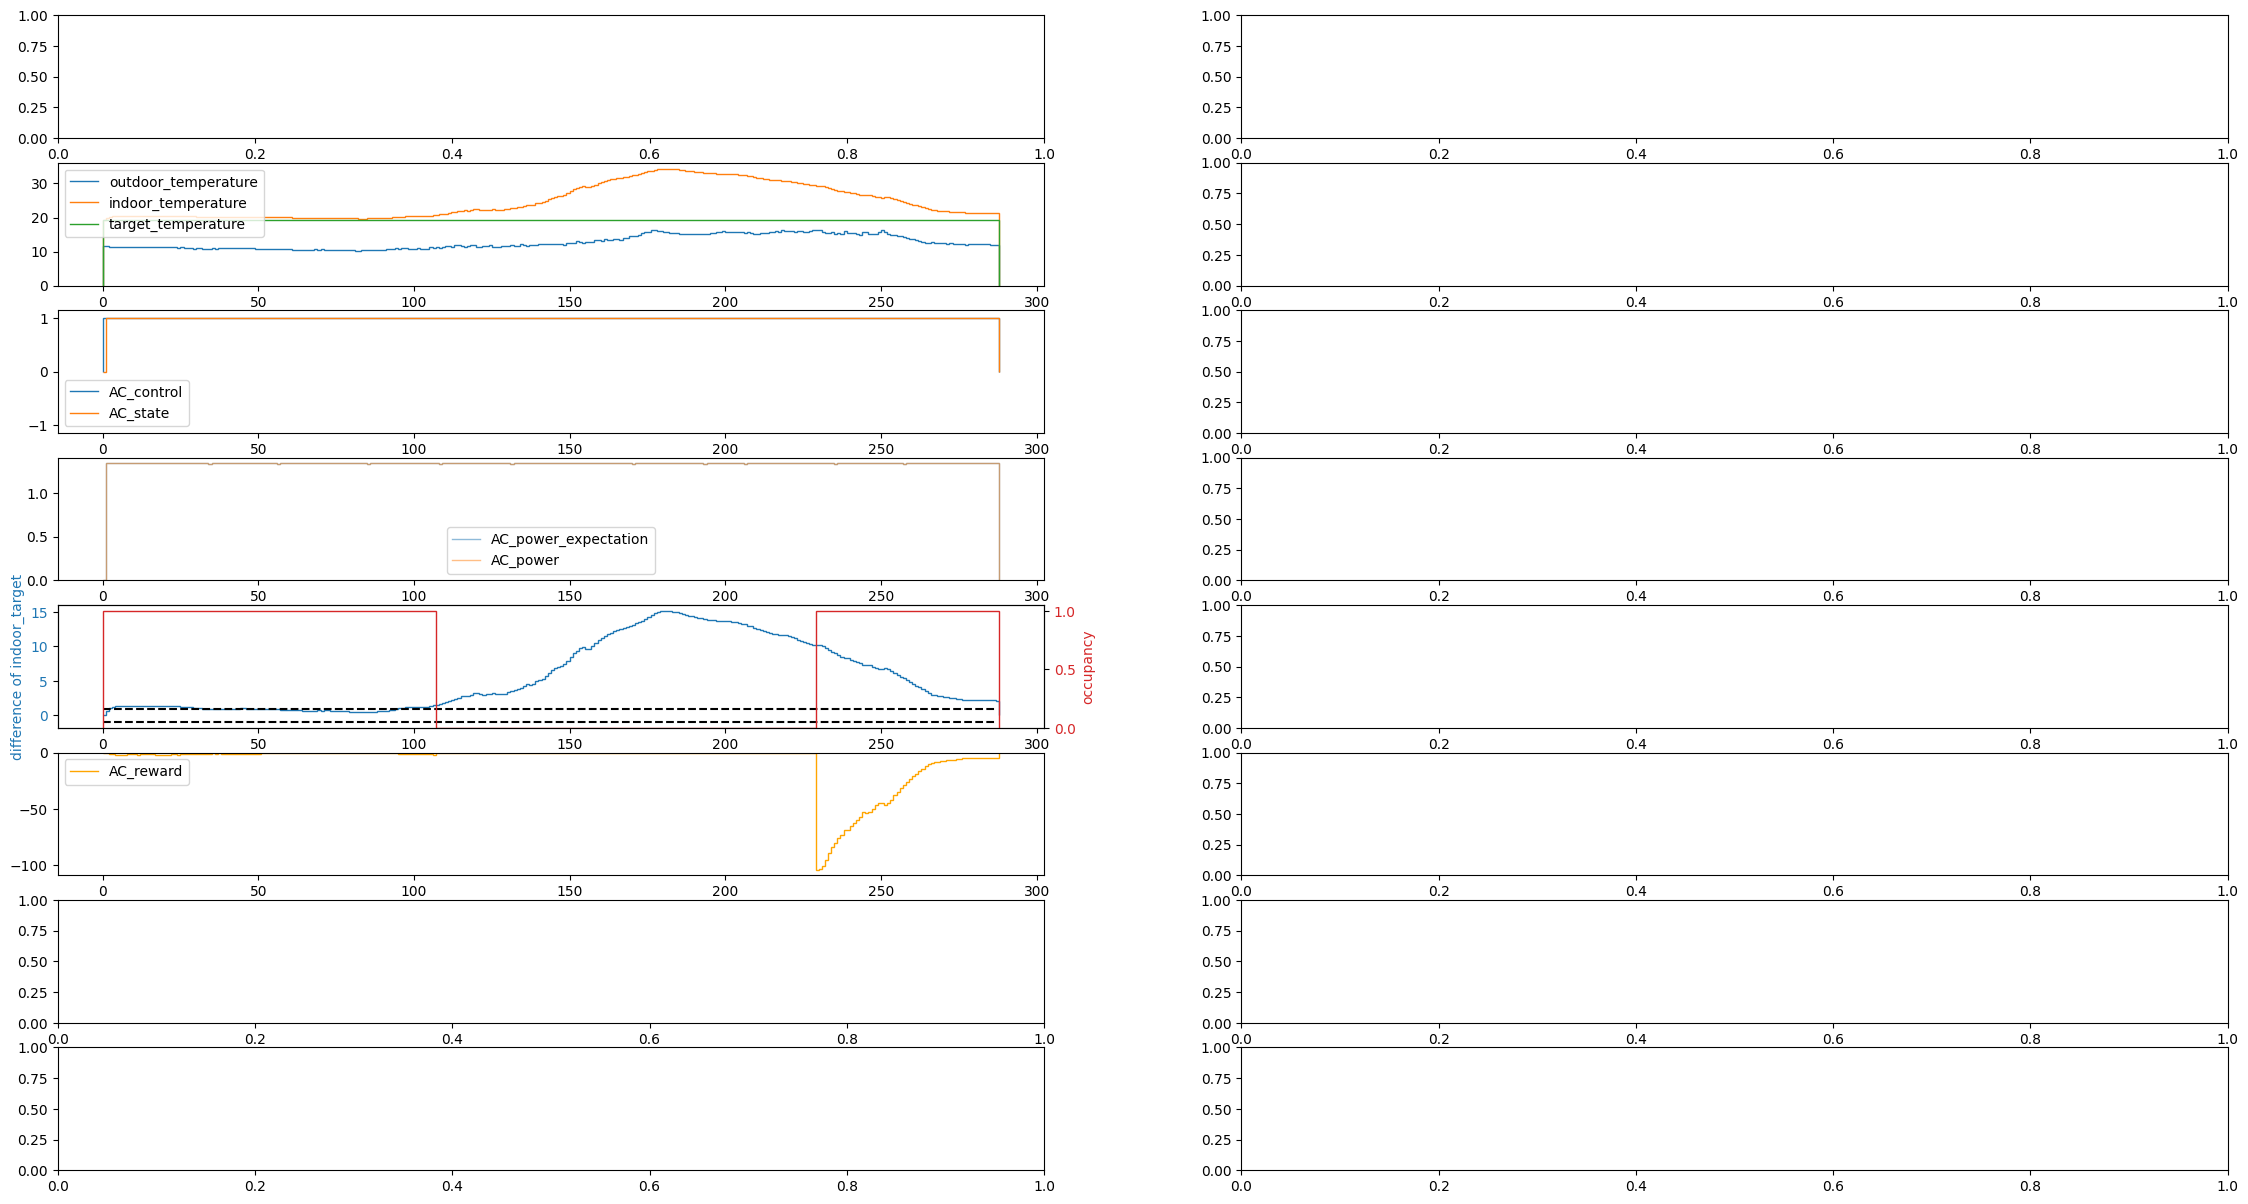

Episode Time: (576, 863)


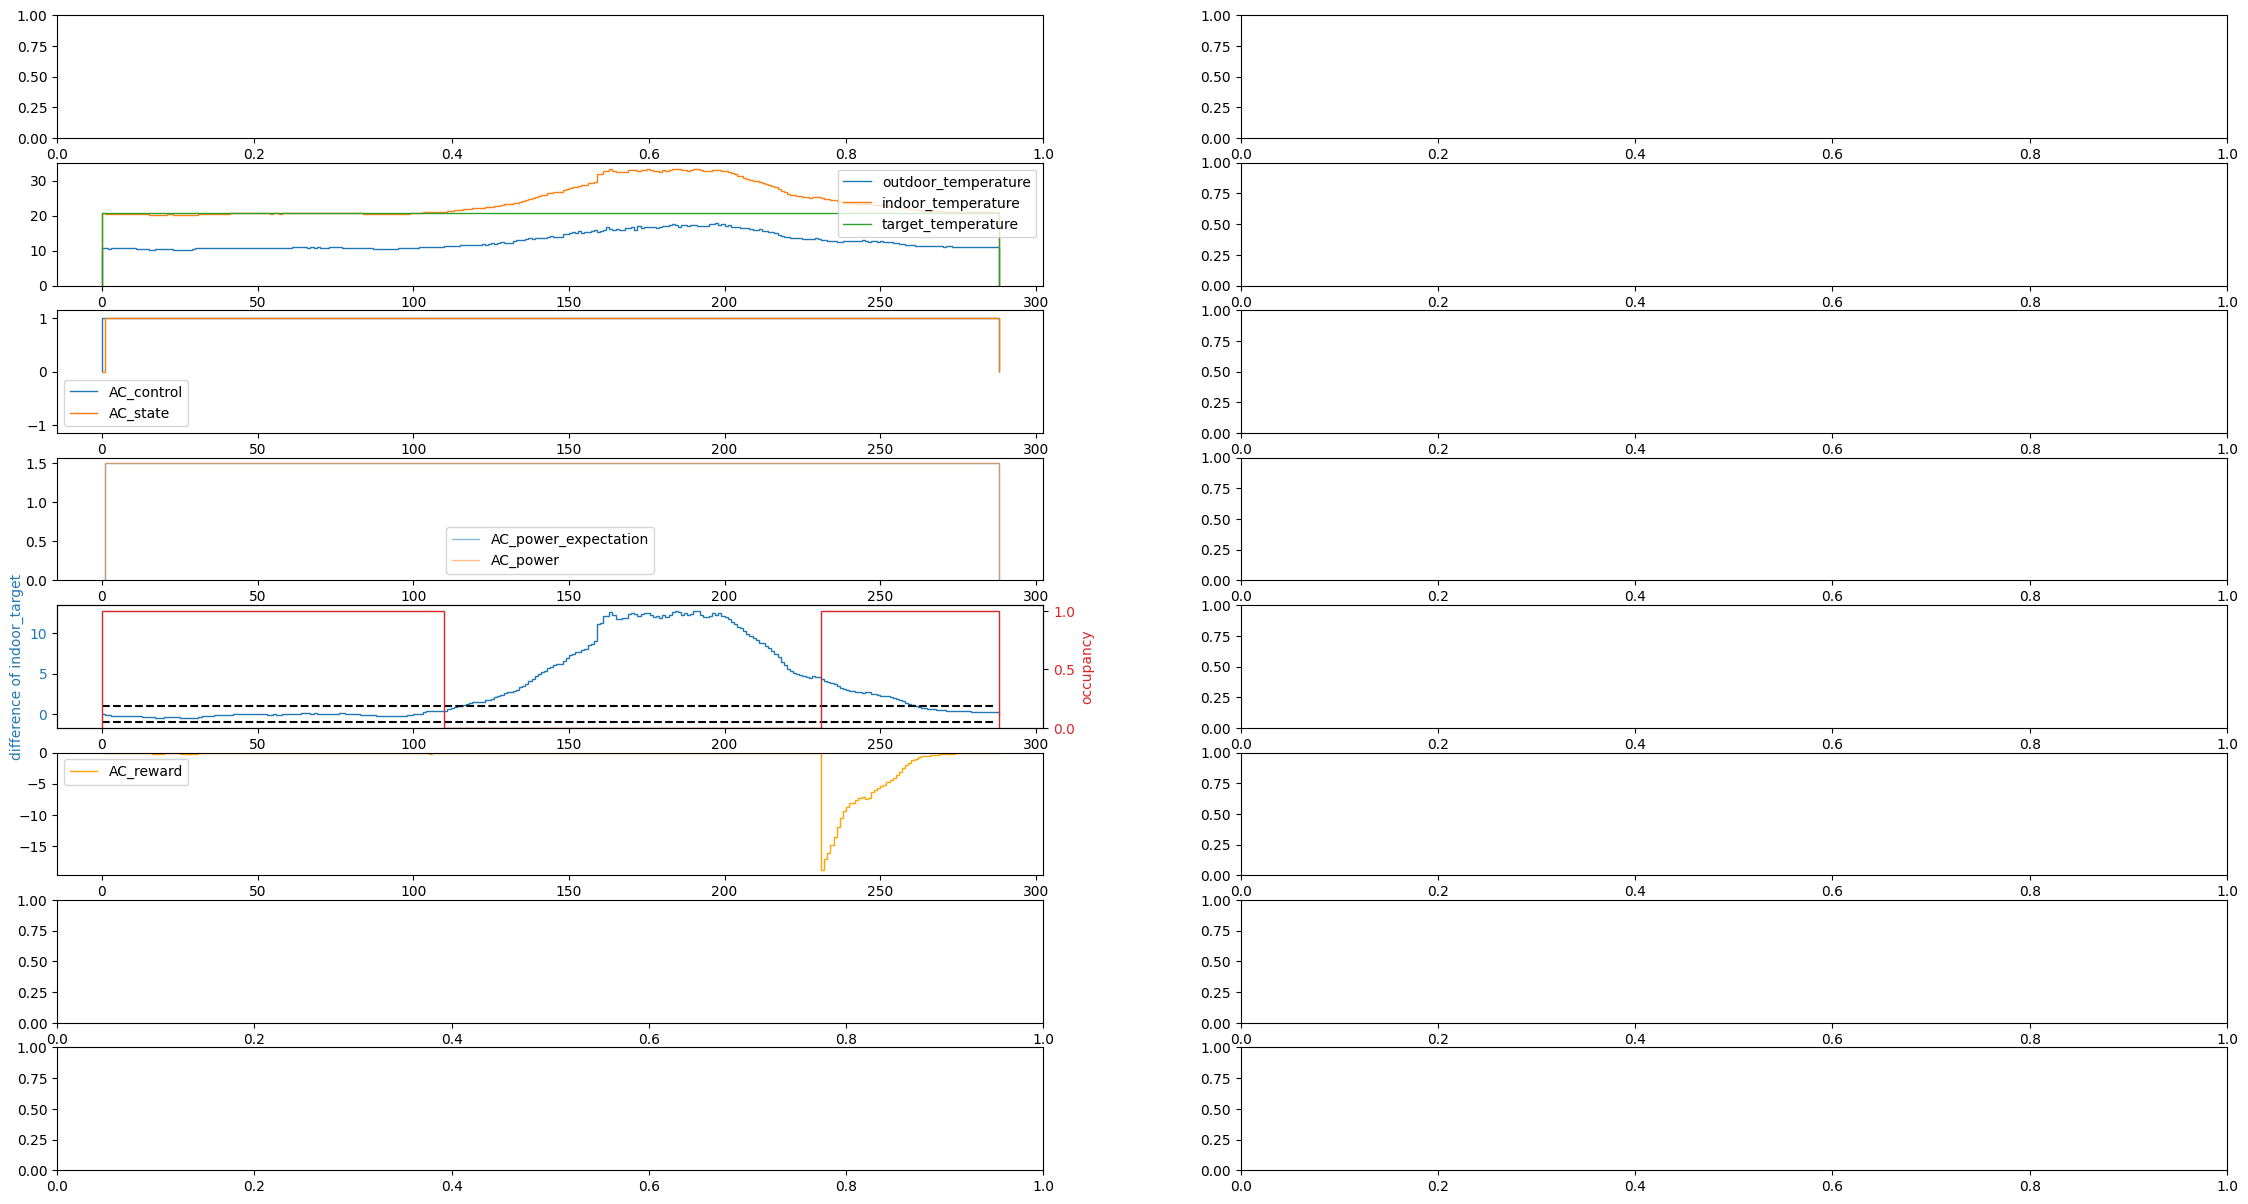

Episode Time: (864, 1151)


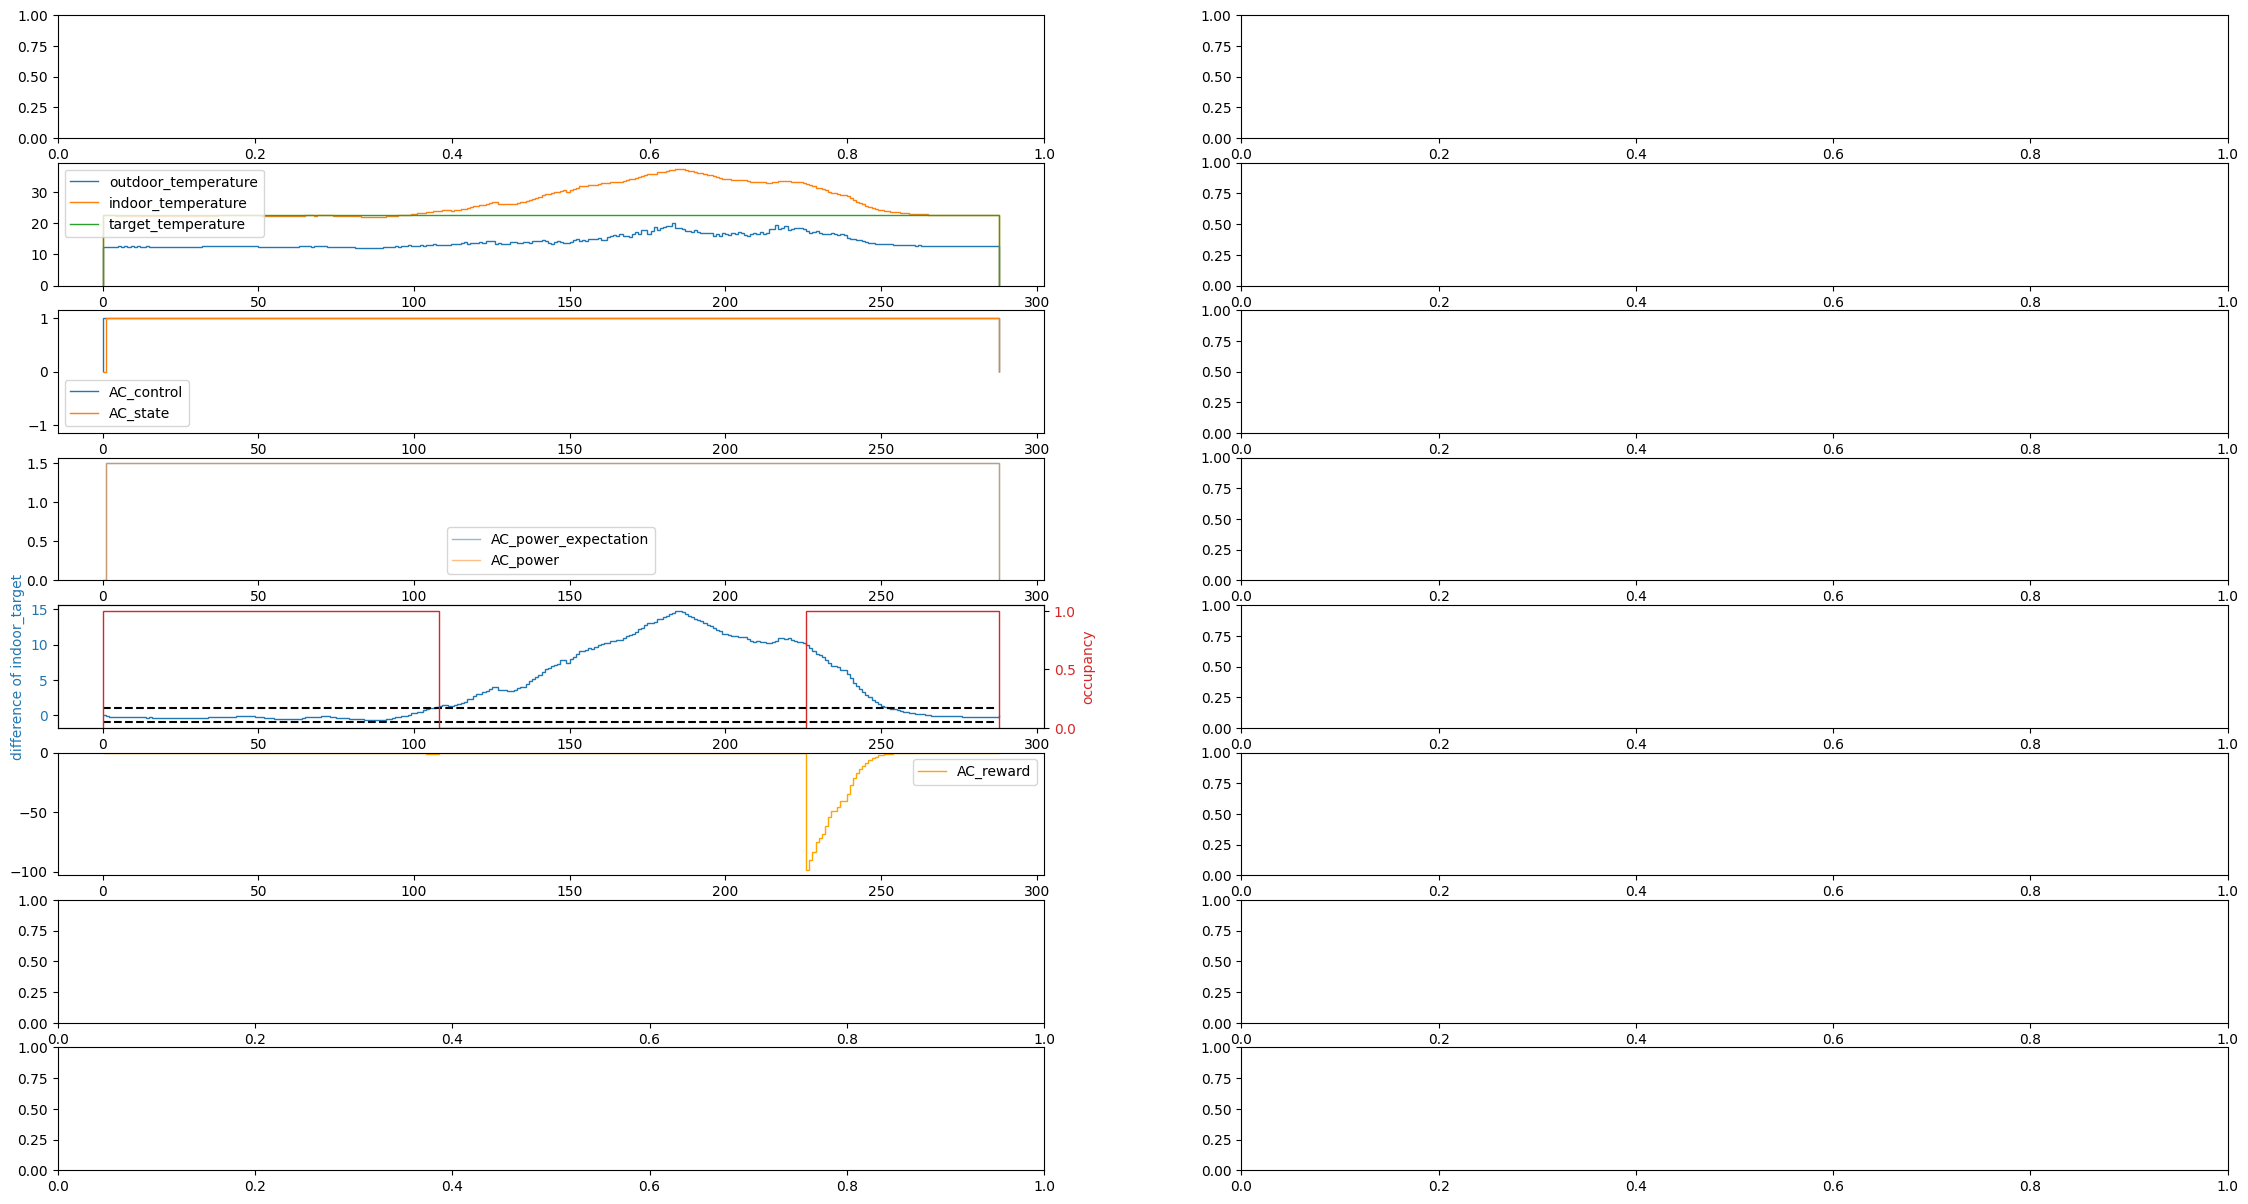

Episode Time: (1152, 1439)


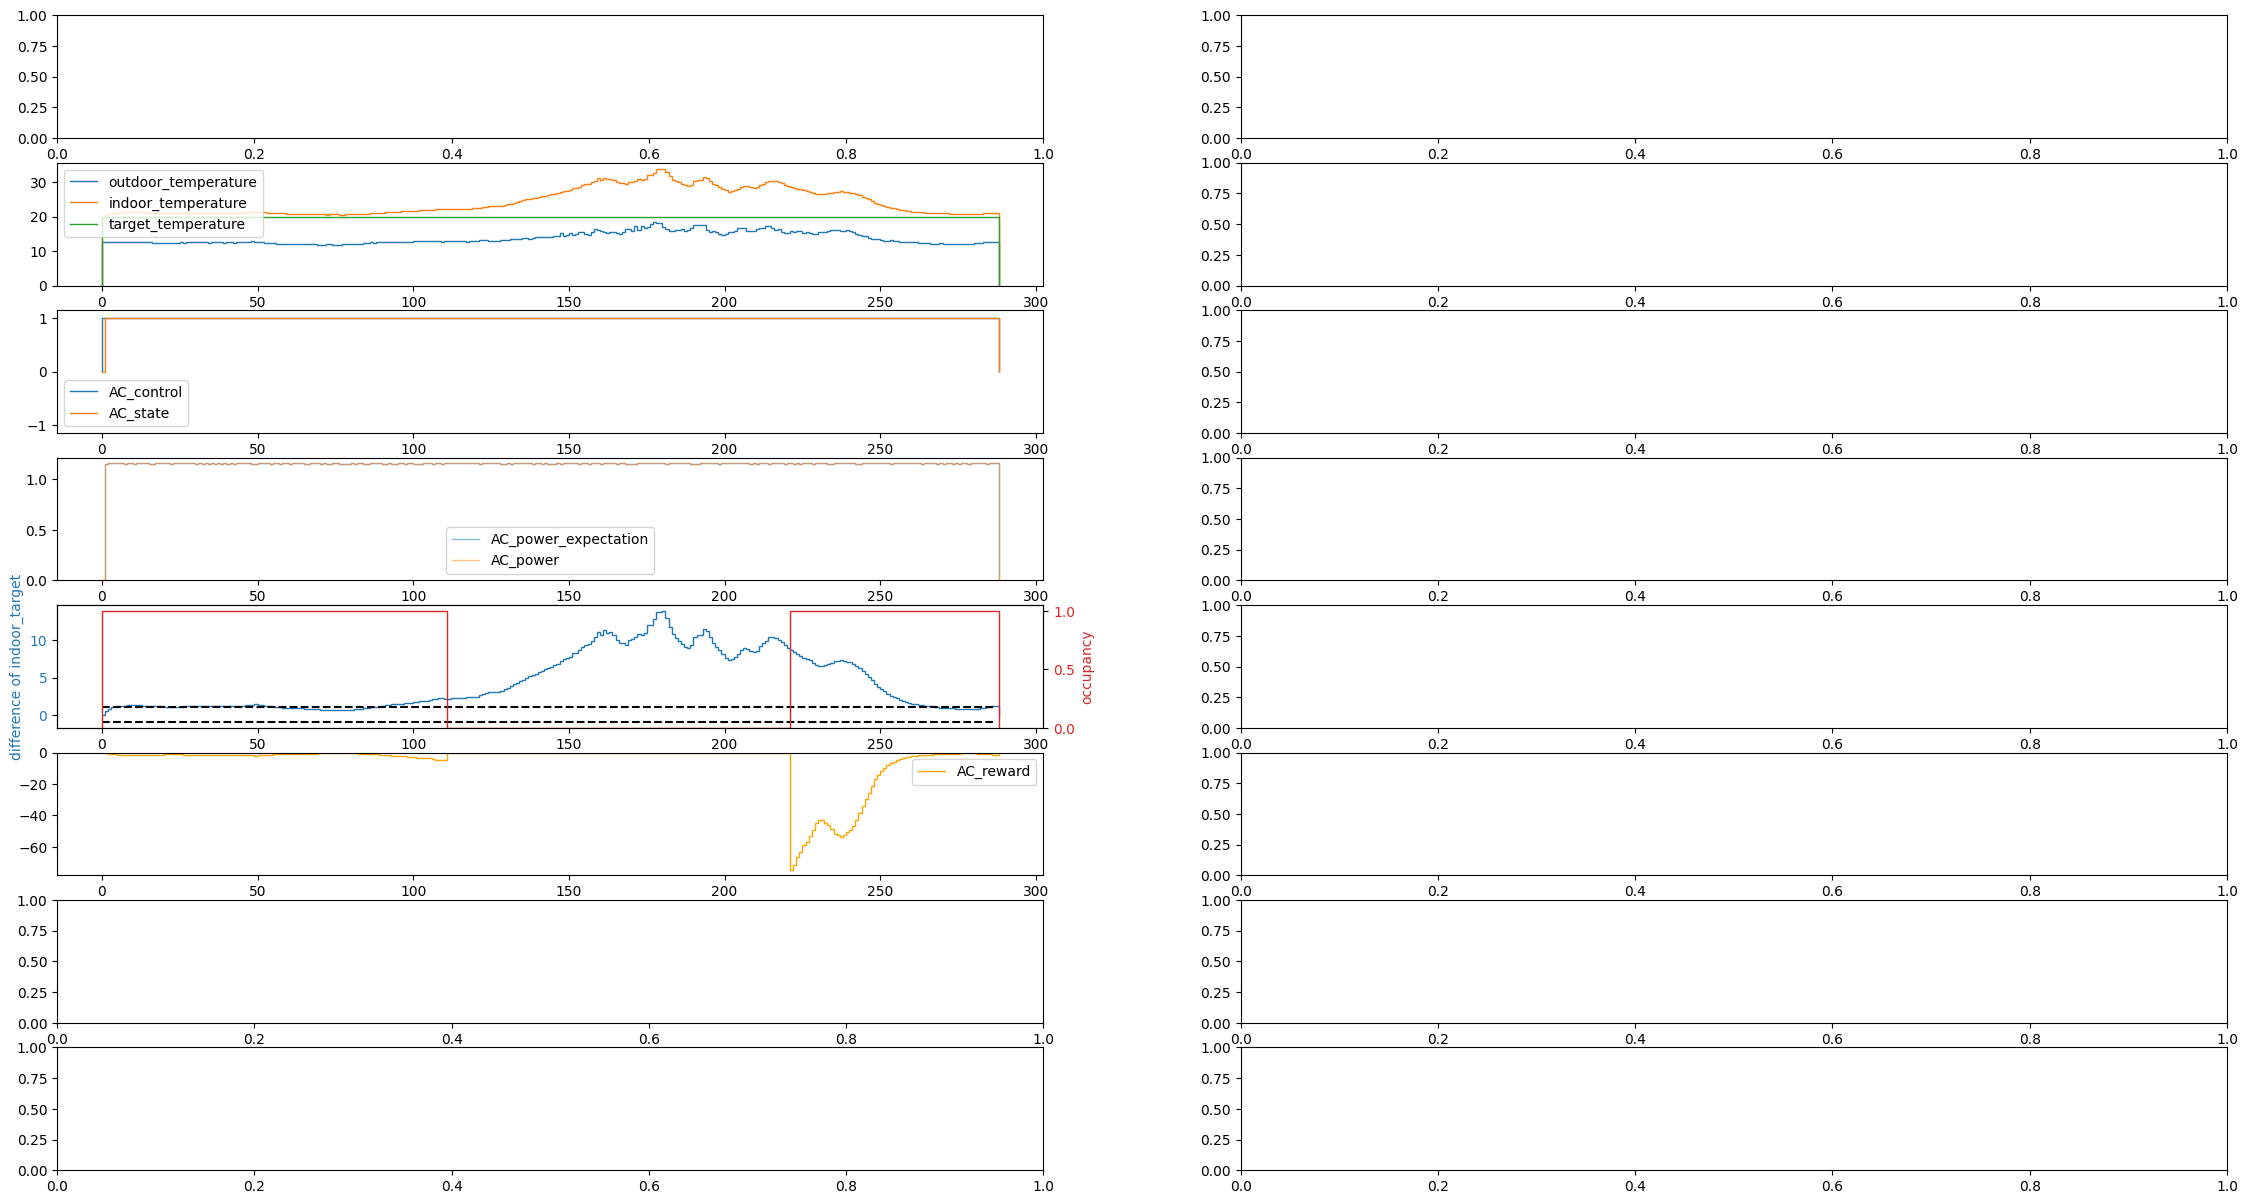

Episode Time: (1440, 1727)


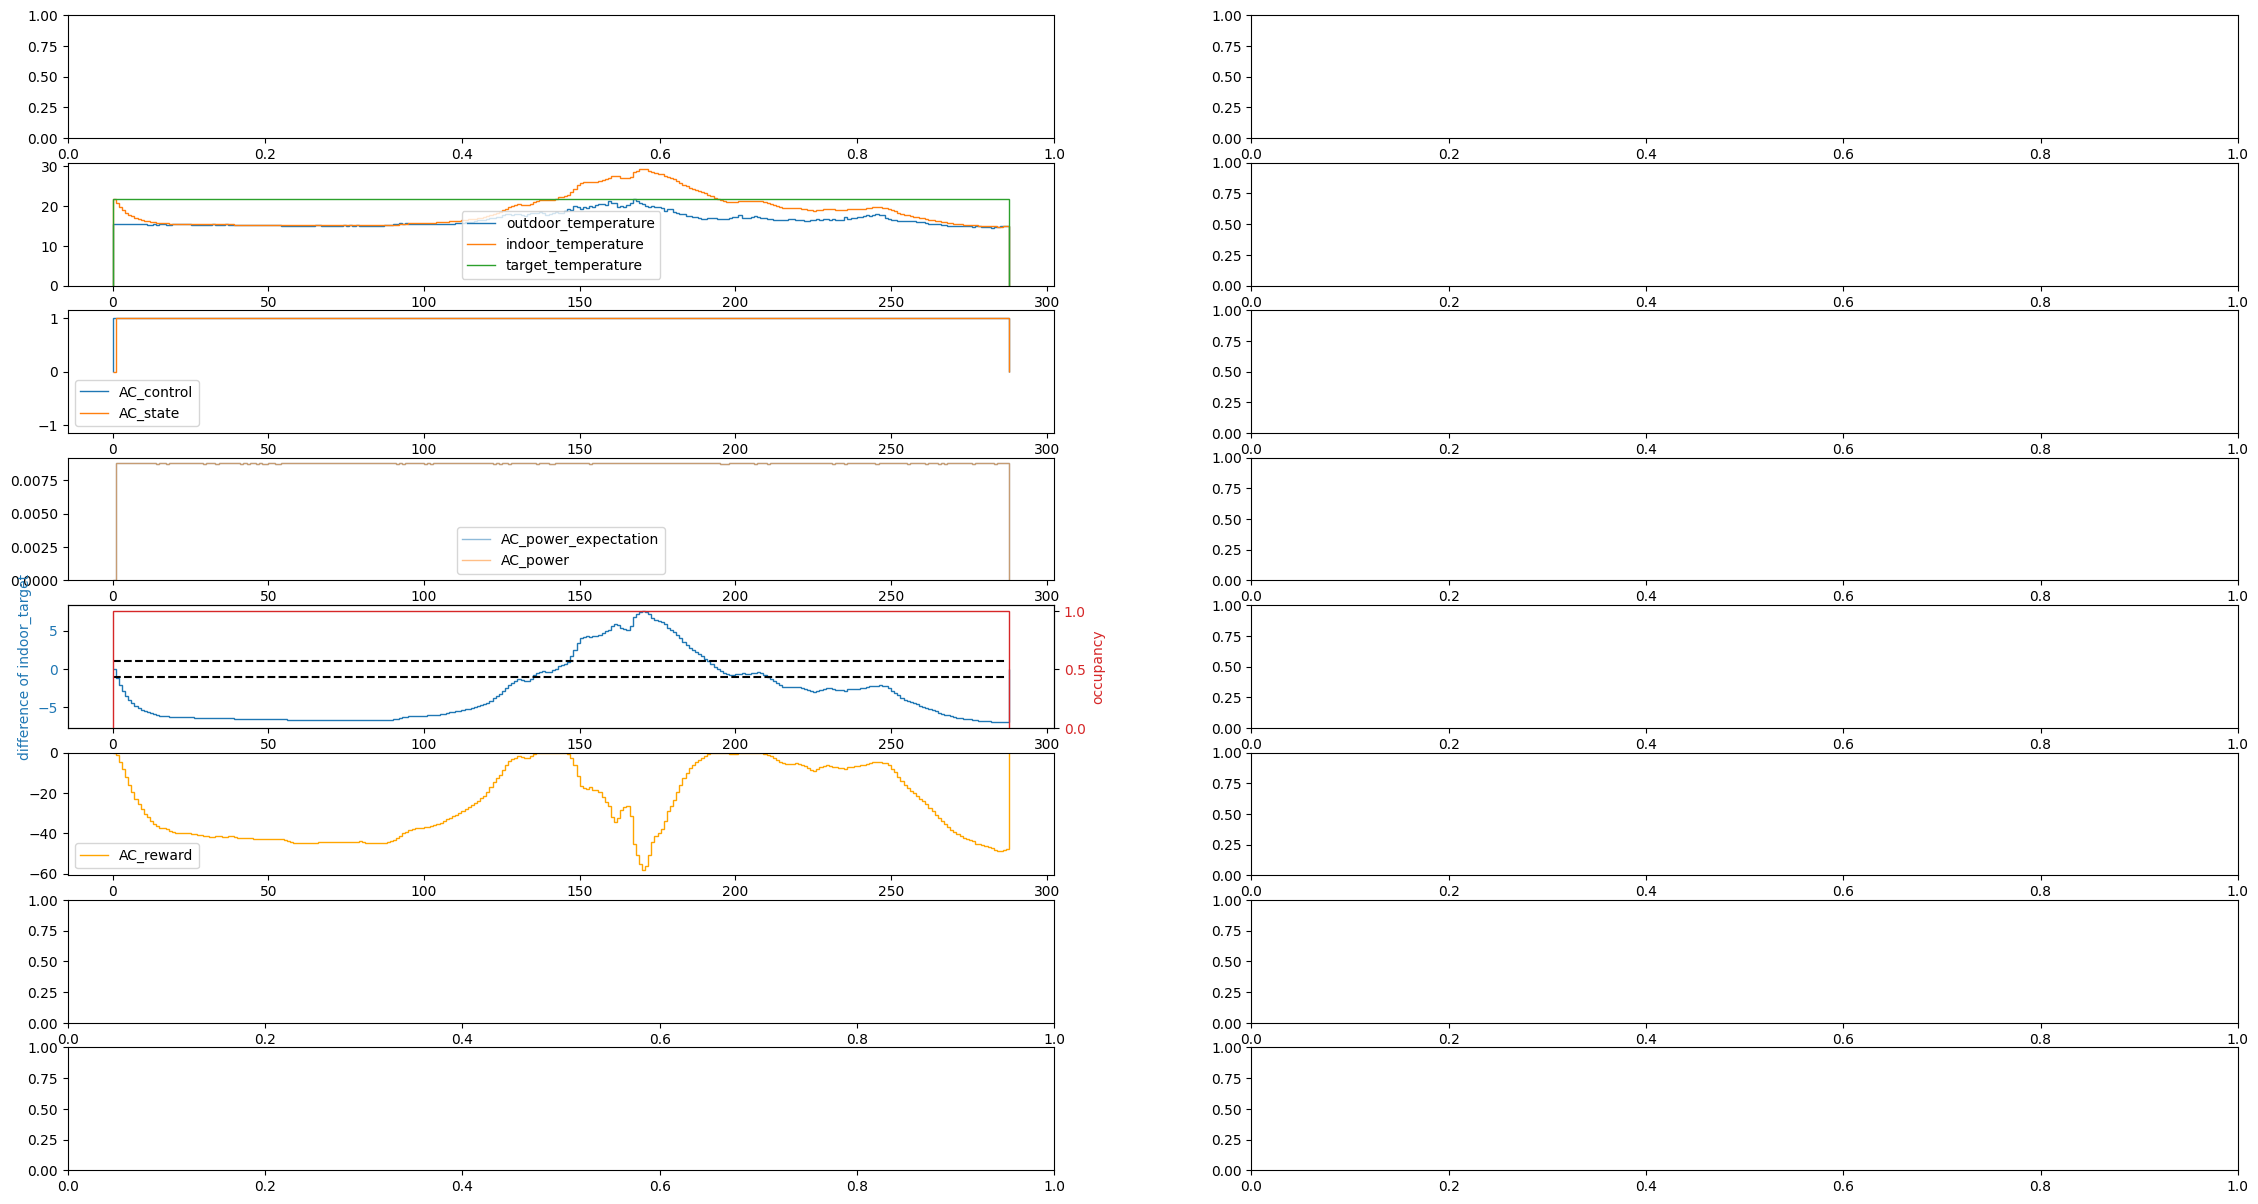

Episode Time: (1728, 2015)


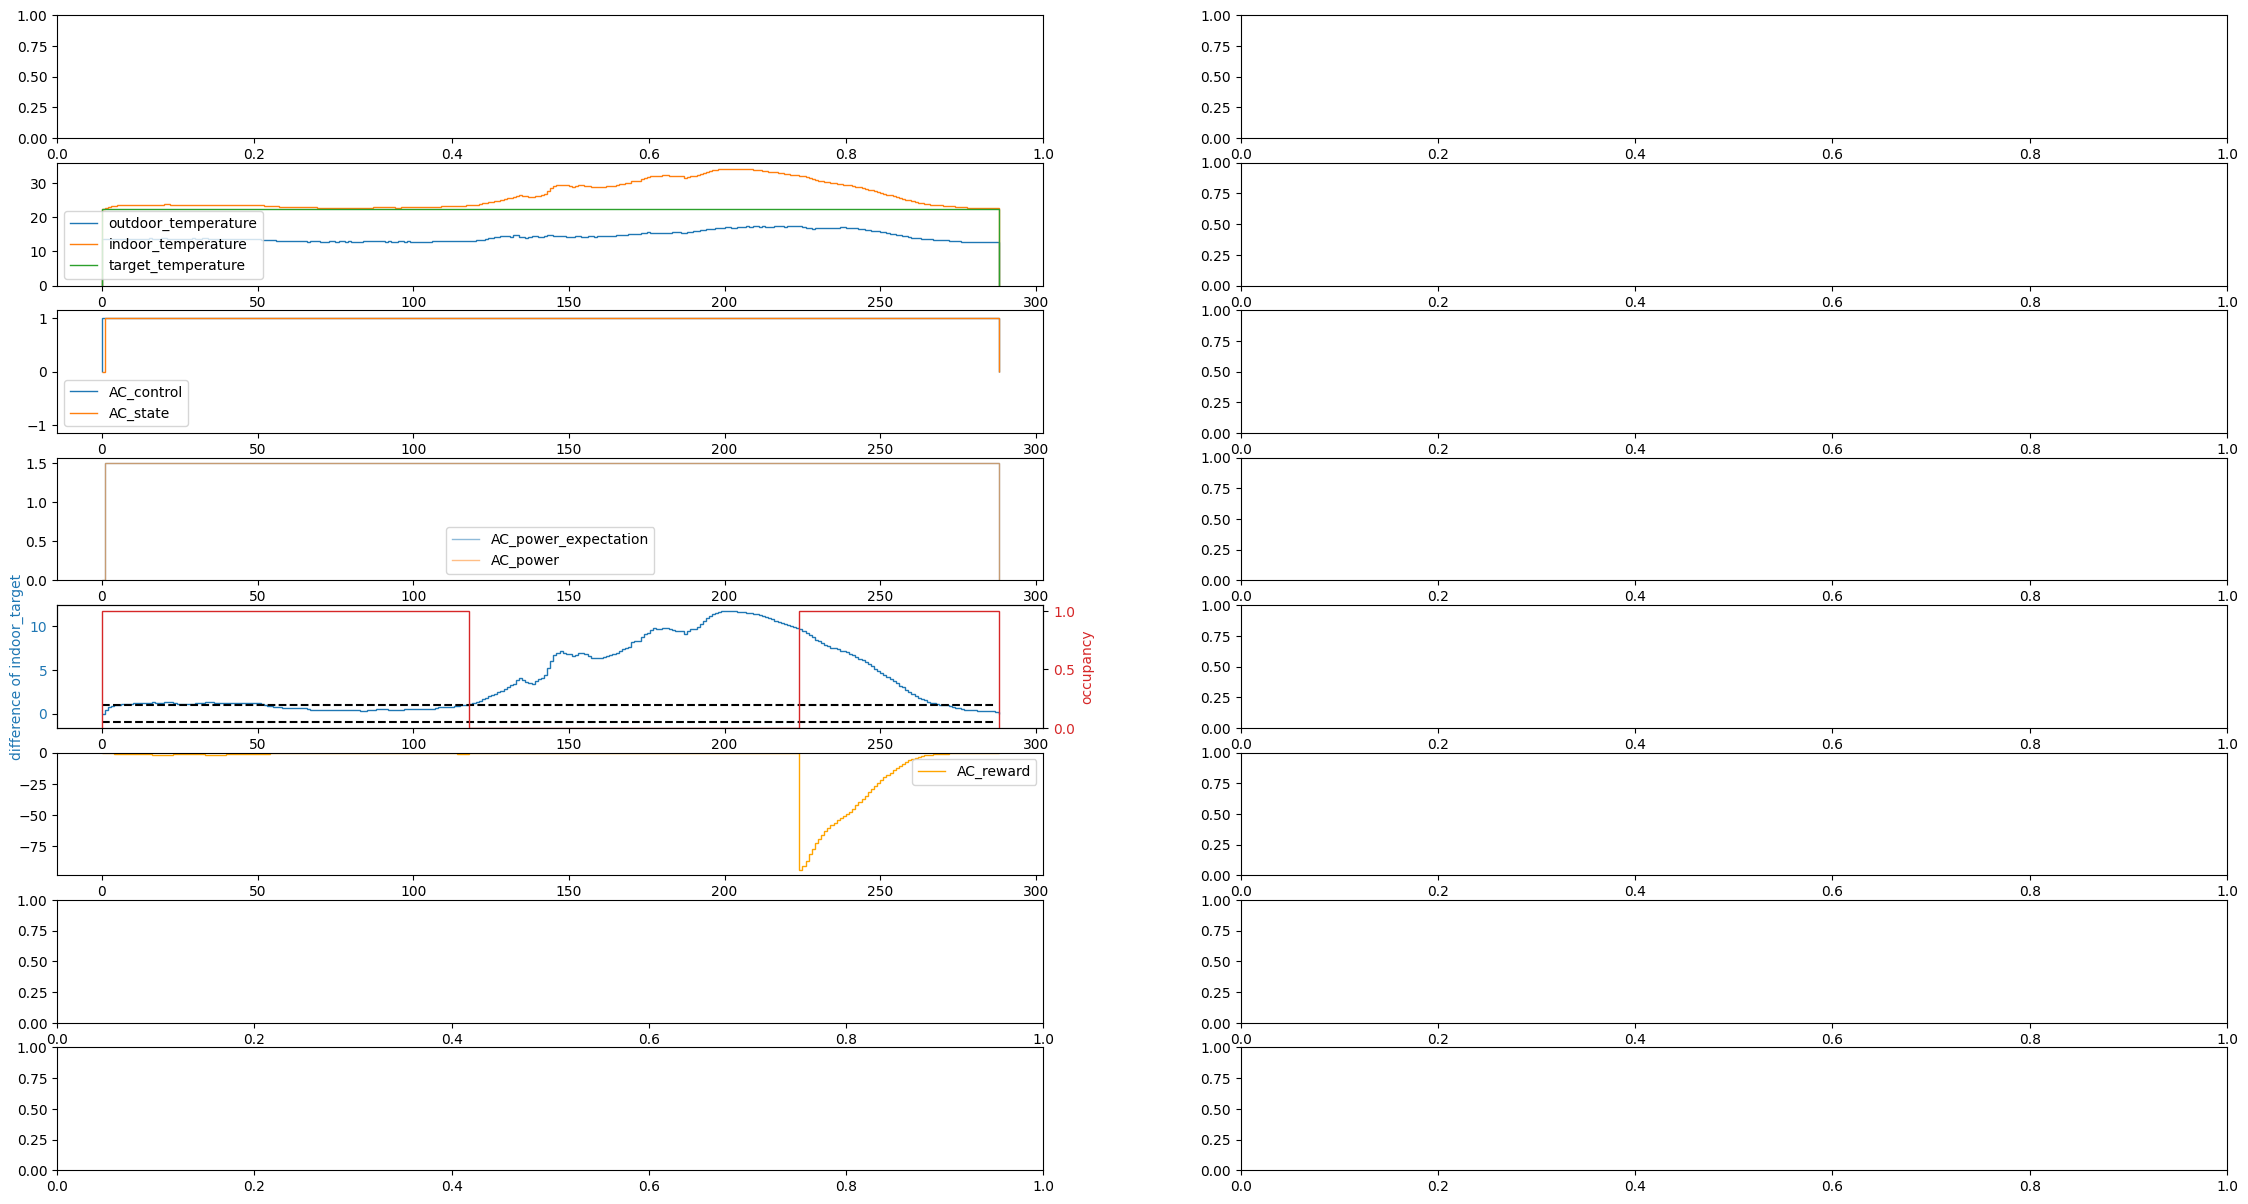

Episode Time: (2016, 2303)


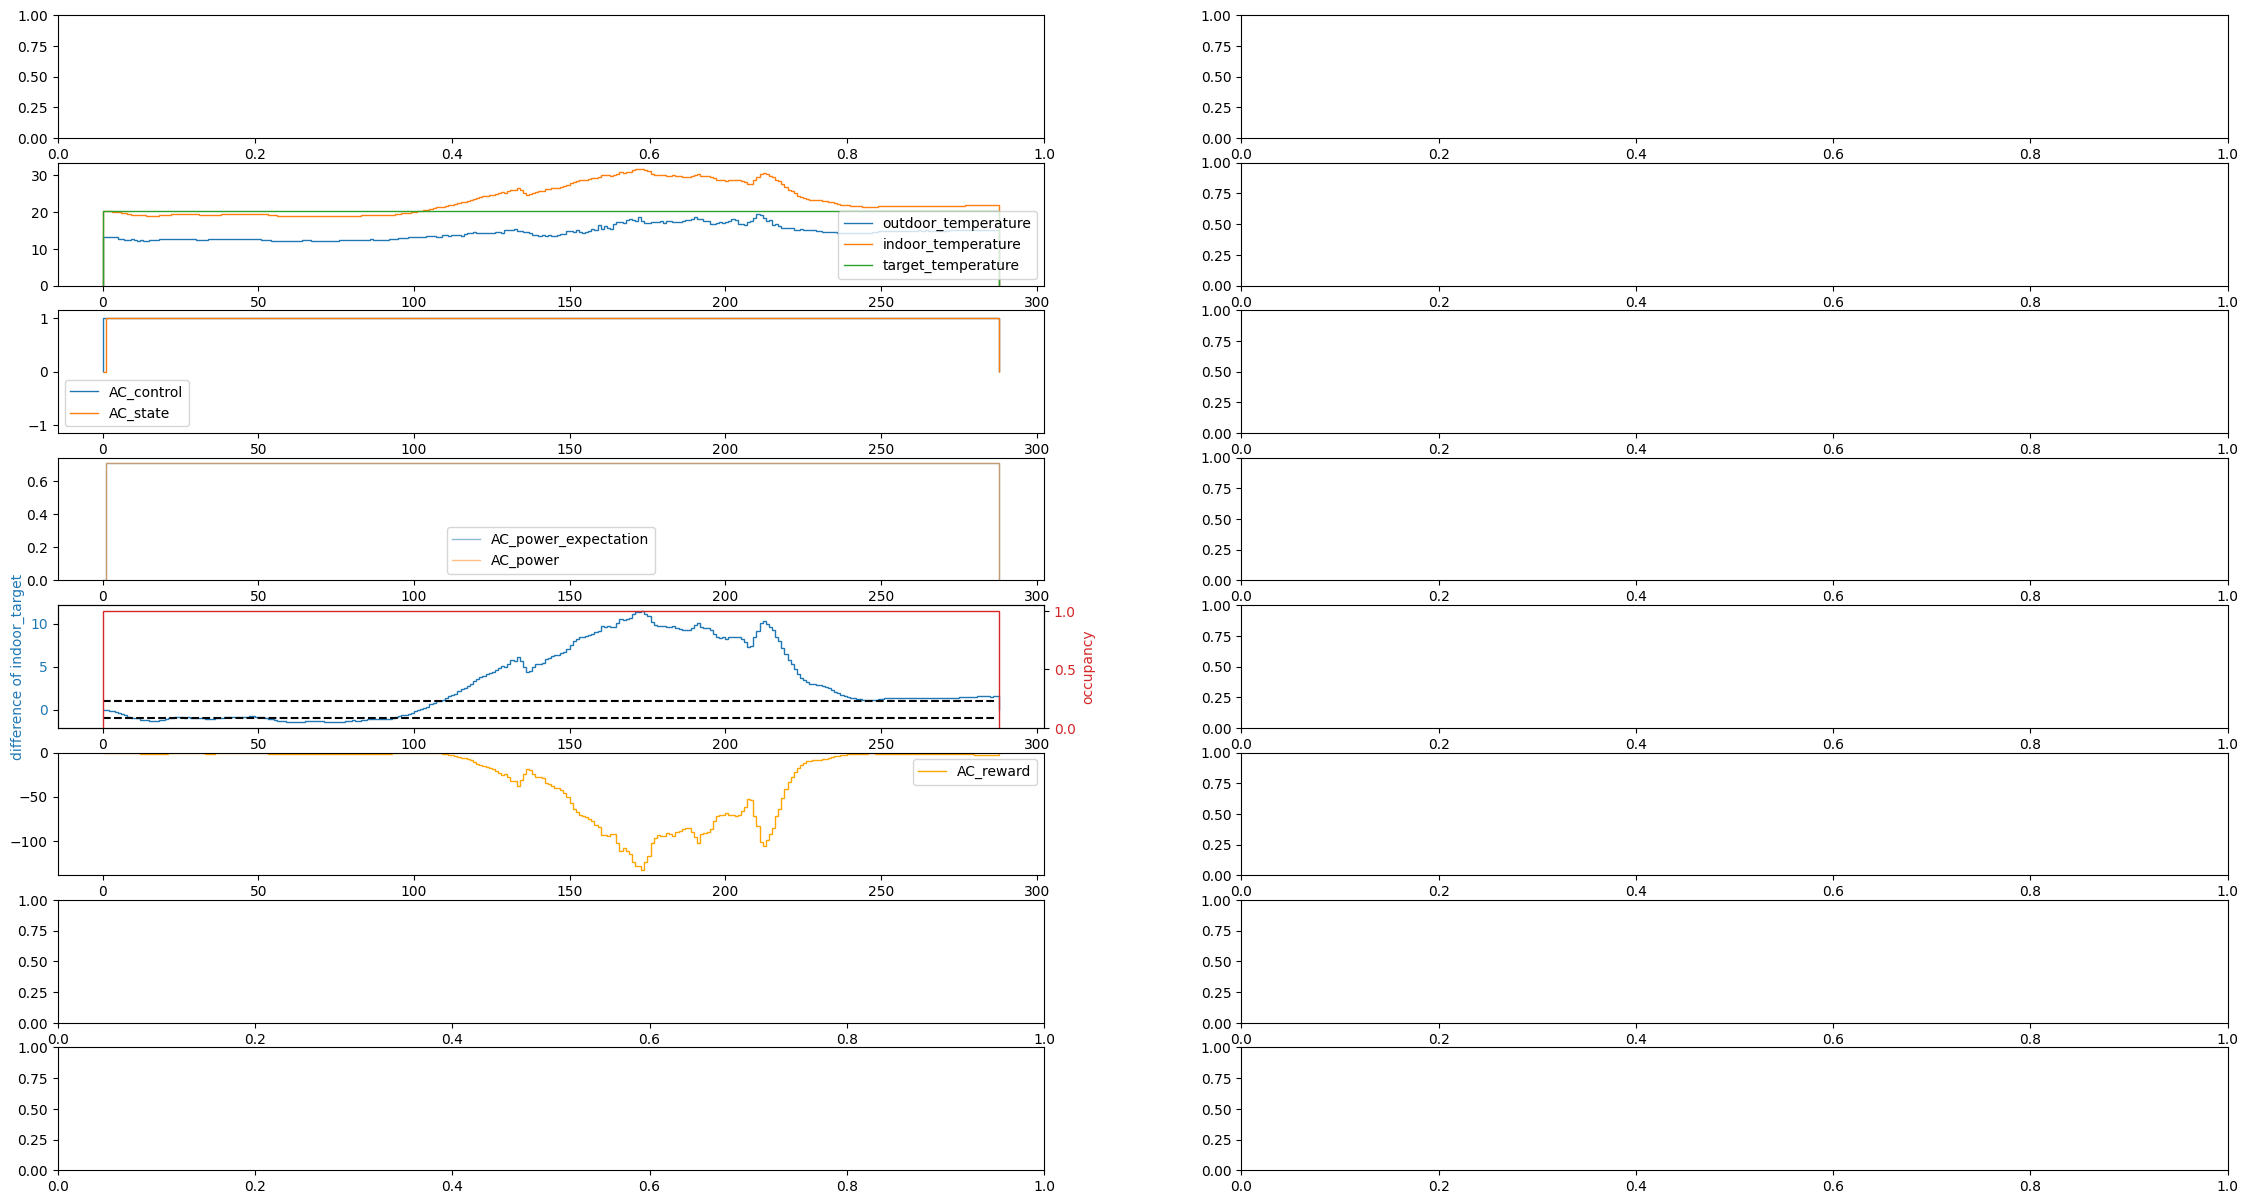

Episode Time: (2304, 2591)


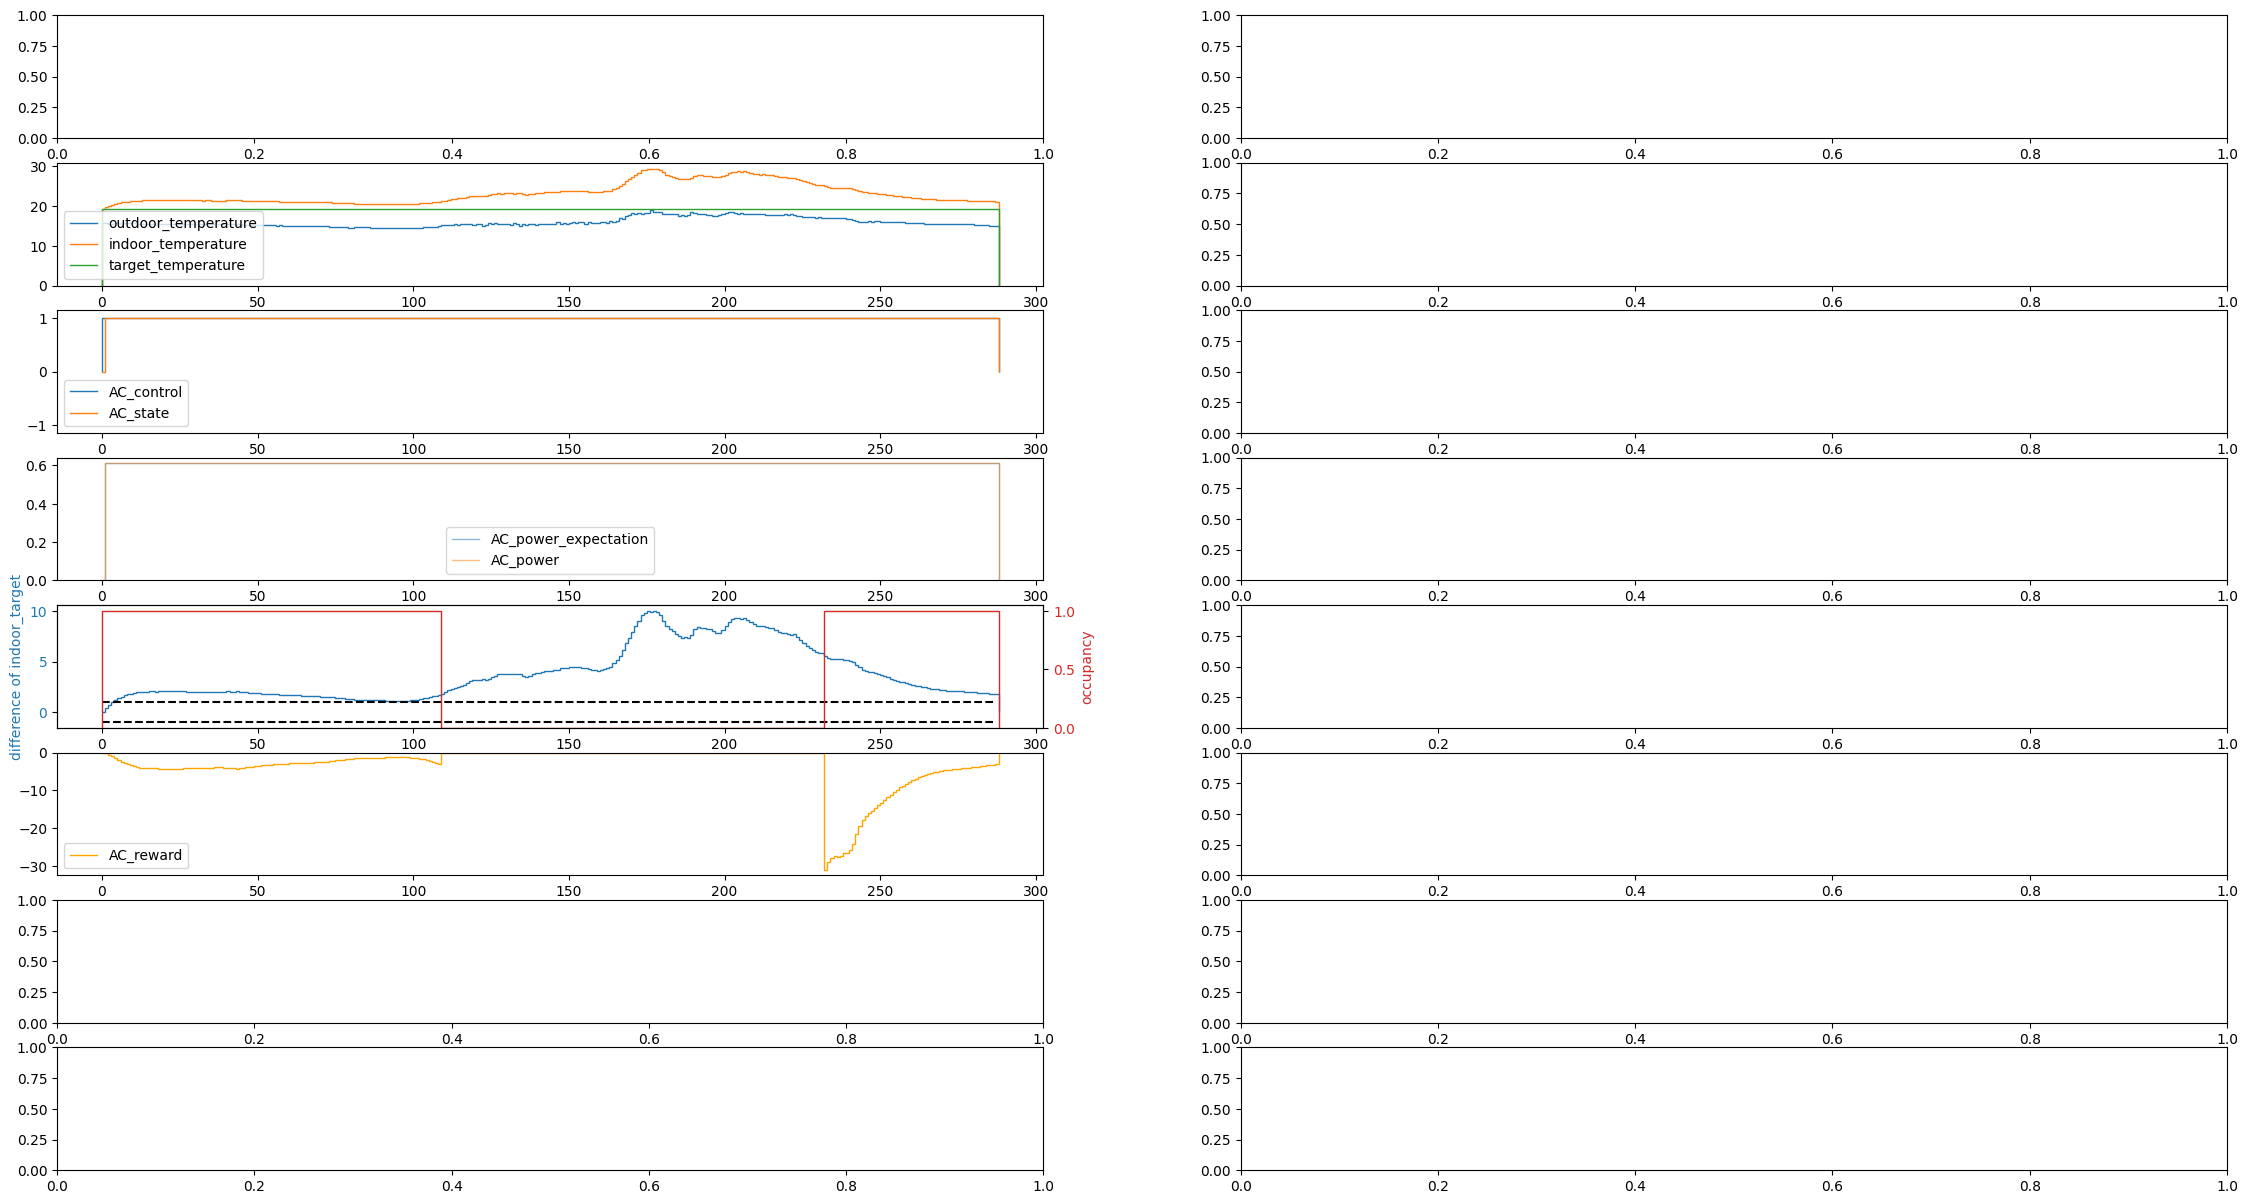

Episode Time: (2592, 2879)


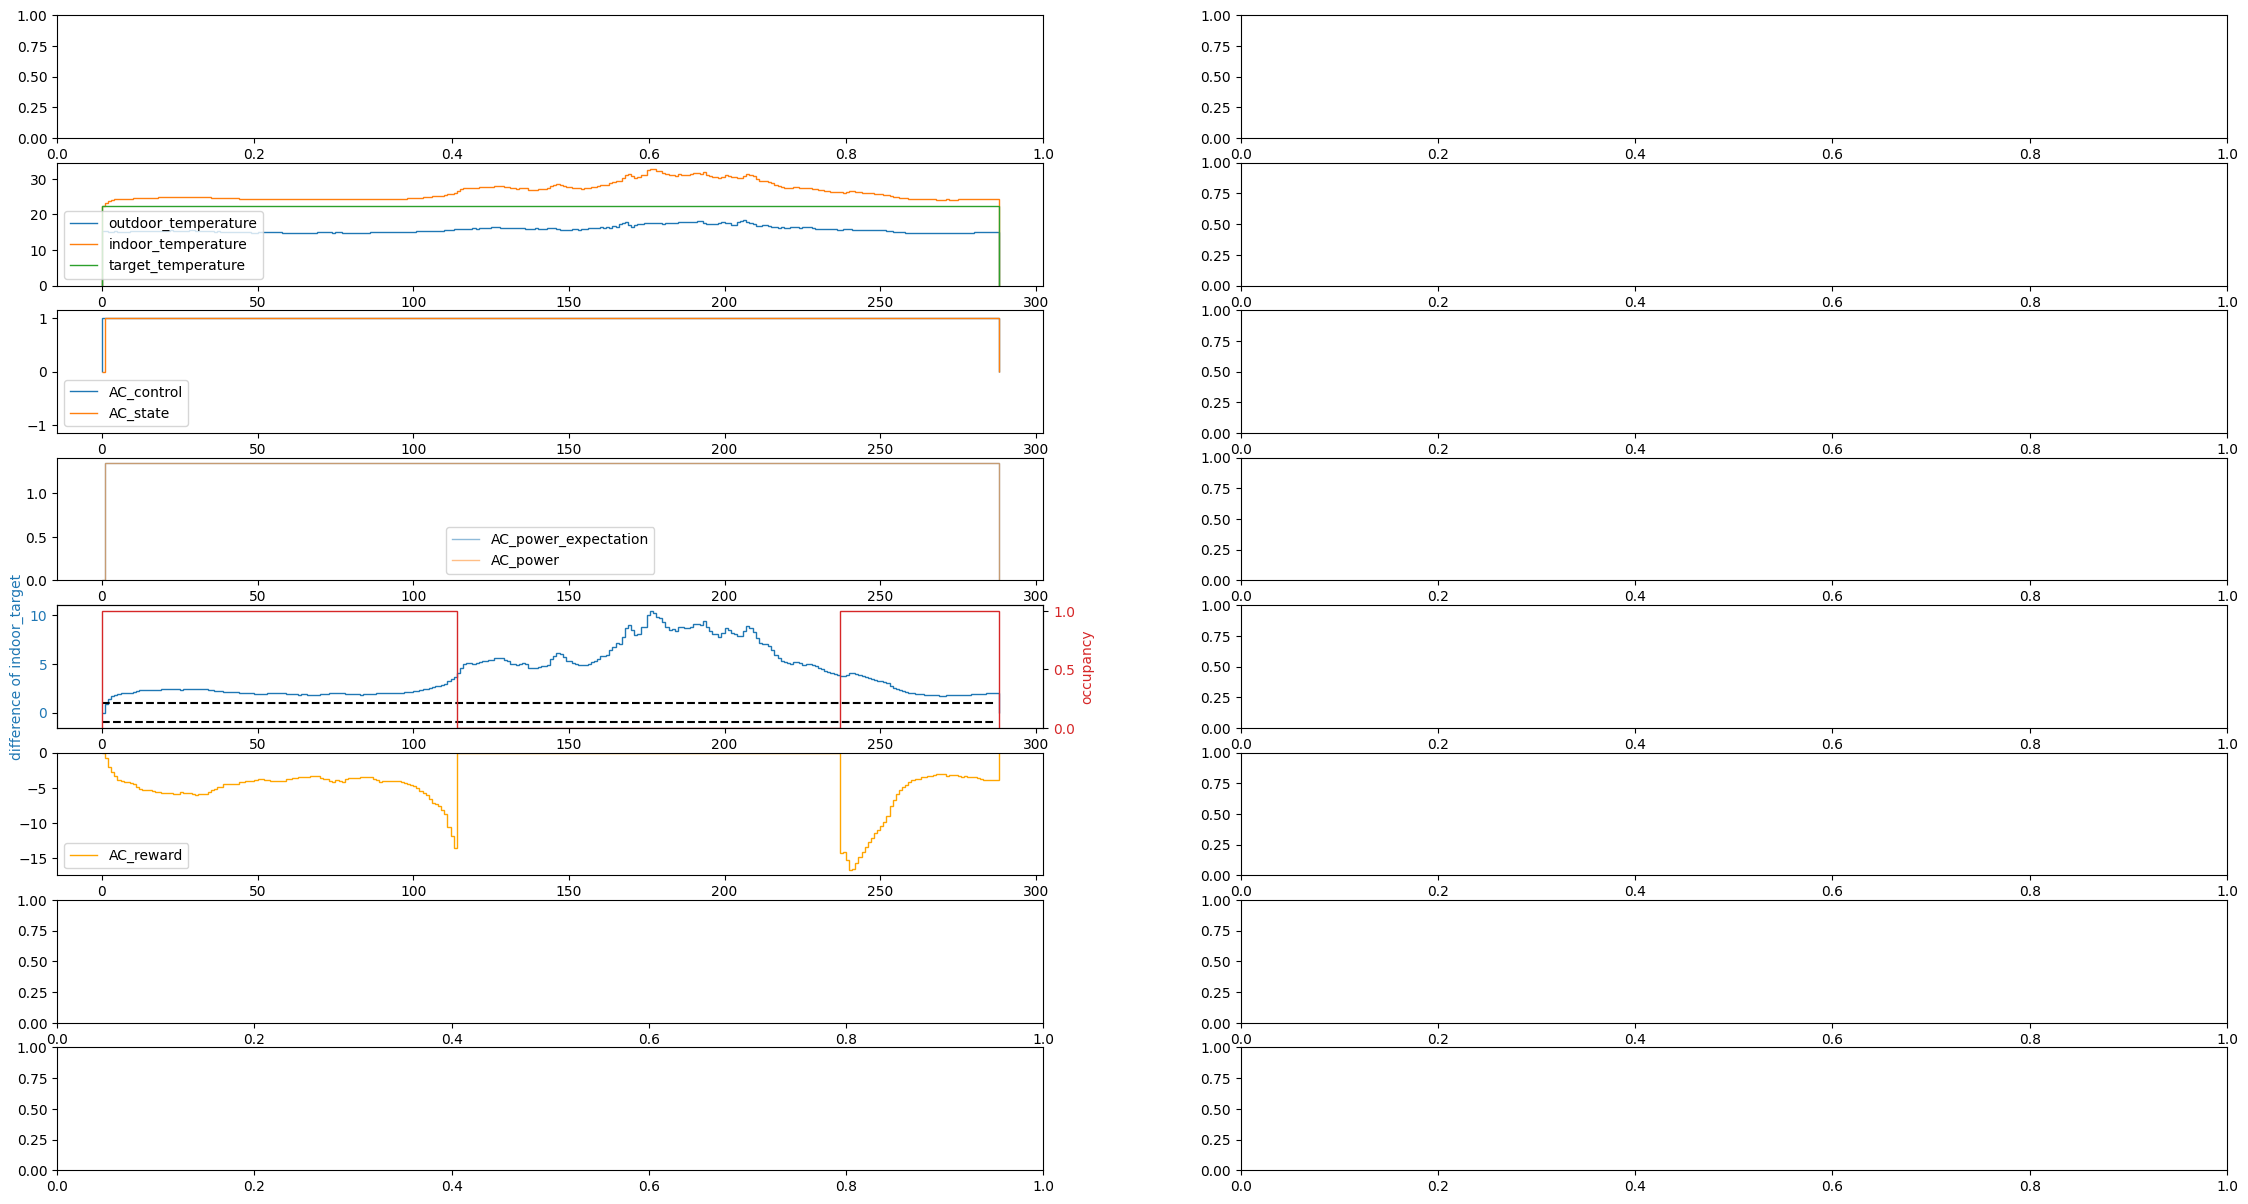

Episode Time: (2880, 3167)


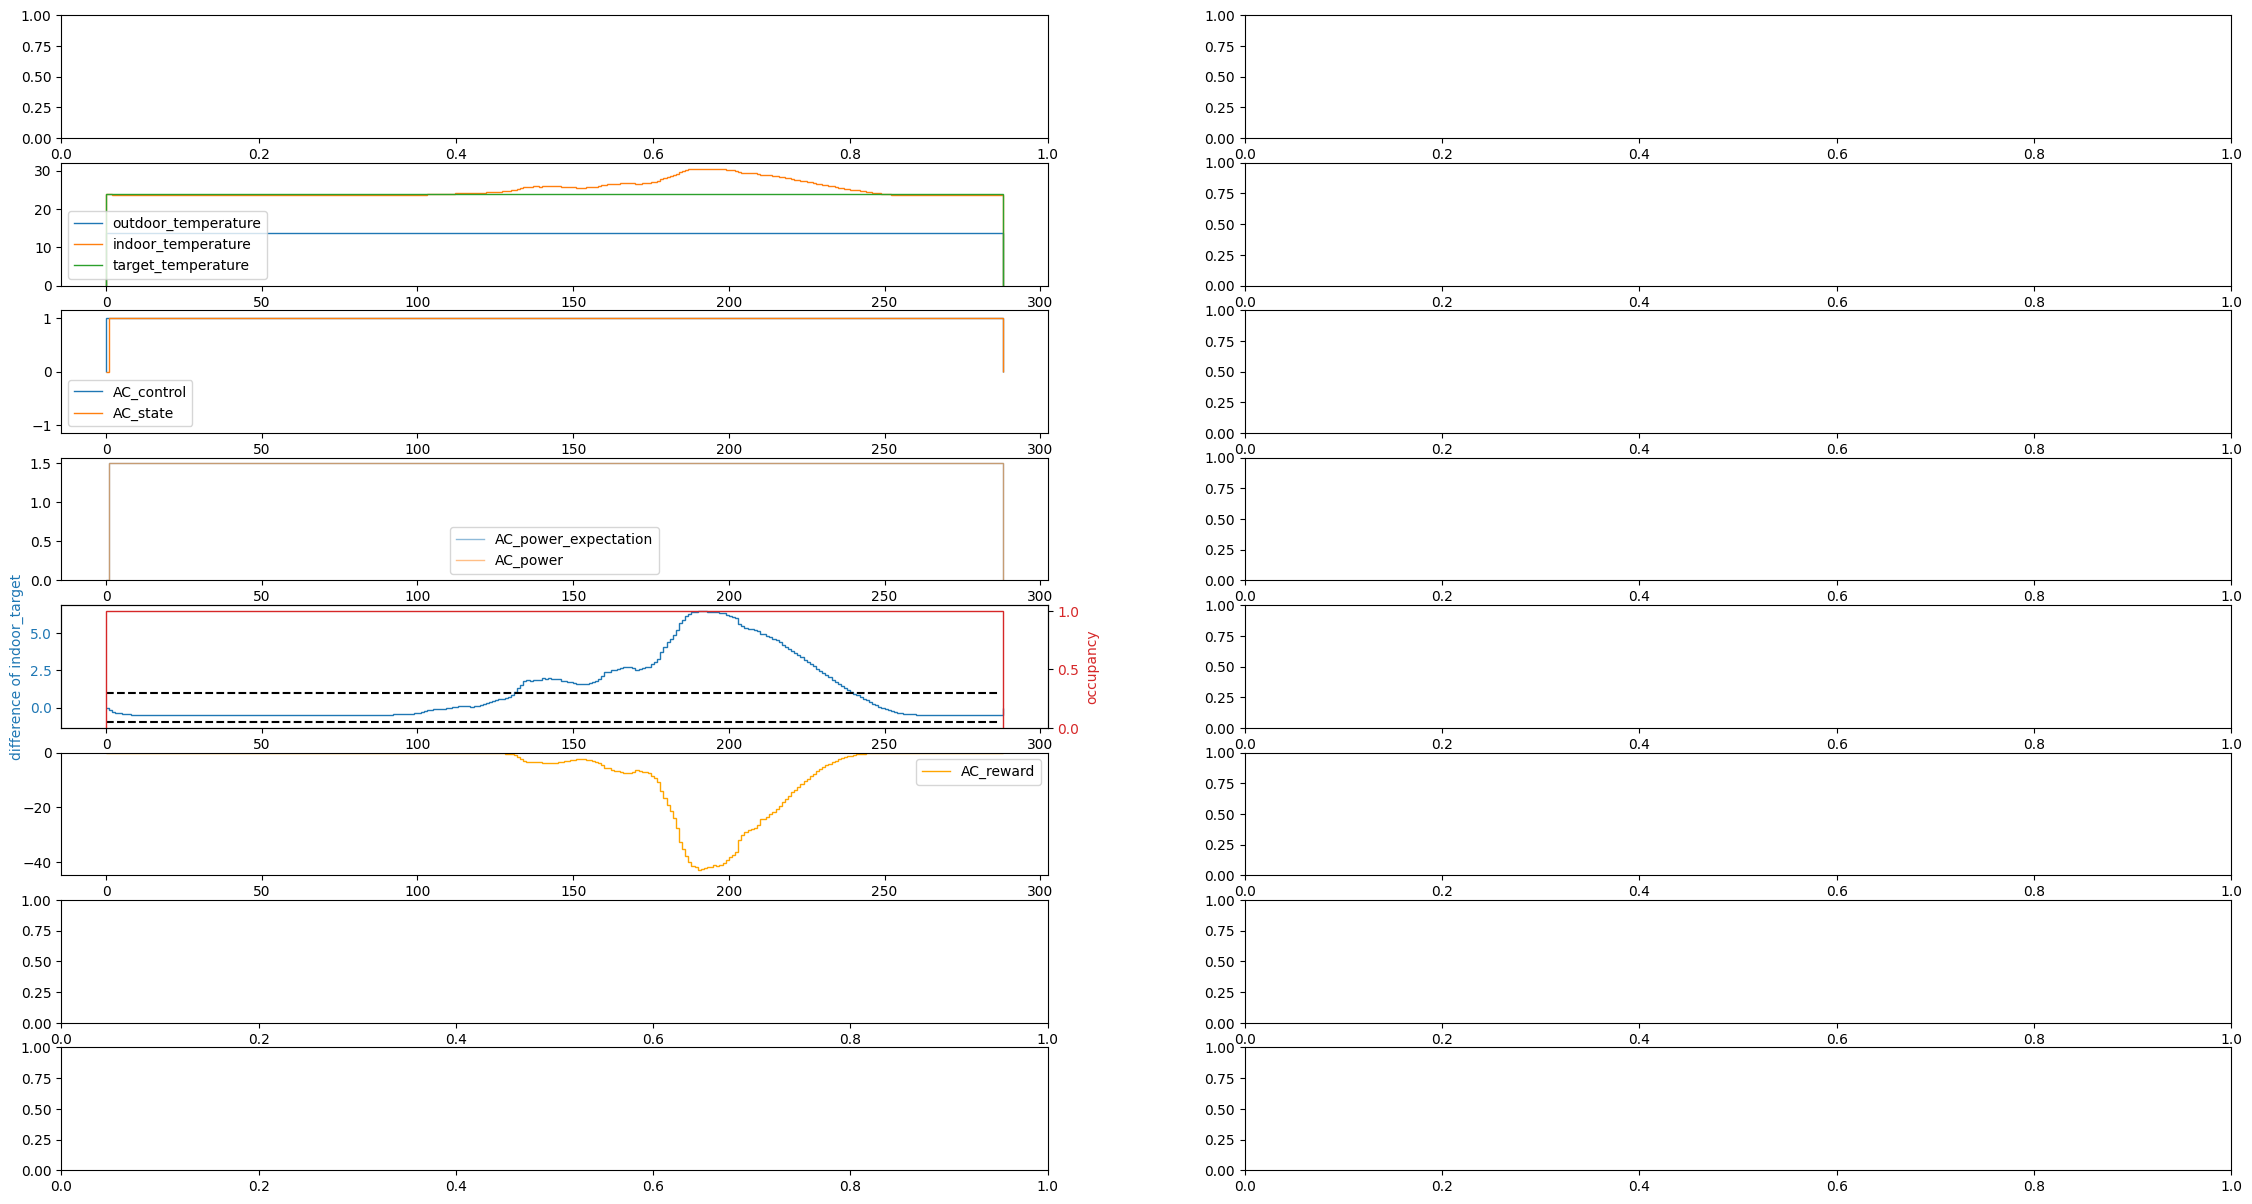

In [7]:
"""
Rendering the environment
"""
test_env_kwargs = env_attr
test_env_kwargs['mode'] = 'test'
test_env_kwargs['random_episode_split'] = False
test_env = sa_env(**test_env_kwargs).unwrapped
renderer = Renderer(env=test_env, render_mode='episode')
test_env.reset()
for e in range(10):
    env_state, _ = test_env.reset()
    agent_id = test_env.agents[0]
    state = env_state[agent_id]
    done = False

    while not done:
        action = trained_agent.take_action(state)
        env_action = {agent_id: action}
        env_next_state, env_reward, env_done, _, _ = test_env.step(env_action)
        renderer.collect()
        done = env_done[agent_id]
    renderer.render()
